# Text Classification and Quantitative Evaluation
#### adapted from sample from Jeremy Merrill for Lede 2025


This notebook classifies internal charges in the NYPD Discipline Library (using a Legal Aid Society database) using the OpenAI interface.

It includes a cost estimation and code for quantitative evaluation (seeing how you did, then adjusting to try to do better).


Data source: cleaned in a separate notebok, but original data comes from: https://github.com/the-legal-aid-society/LELU/tree/main/nypd_internal

In [1]:
## installing relevant packages
!pip install --quiet openai strip_tags tiktoken

from dotenv import load_dotenv
import os
load_dotenv()
import pandas as pd
from openai import OpenAI
from IPython.display import display, Markdown
from tqdm.auto import tqdm # makes pretty progress bars
tqdm.pandas()

In [21]:
## setting up API key

#  # uncomment if you're running on your laptop in a datakit
# if you're in Colab, put the API key in the Secrets (the key icon on the far left of the screen.)
# the "Name" needs to be exactly `API_KEY` and you need to make sure that the Notebook Access checkbox is checked.

if IN_COLAB:
  from google.colab import userdata
  api_key = userdata.get('OPENAI_API_KEY_LEDE')
else:
  load_dotenv()
  api_key = os.environ['OPENAI_API_KEY_LEDE']

print("OPENAI_API_KEY_LEDE" in os.environ) 
data= pd.read_csv("nypd_internal_cleaned.csv")


SIZE_OF_SAMPLE = 50
##
## take a random sample to test our prompts against
text_column_name = "Charge.description" 
data_sample = data.sample(n=SIZE_OF_SAMPLE)

True


In [22]:
data_sample.head()

,Unnamed: 0,Officer.Name,Type,Shield..,Tax..,Precinct.Command,Document,Case,Charge.description,Disposition,Penalty
3988,9111,SHIEED A HANIFF,3,NaN,944077,069-069 PRECINCT,NaN,2014-11630,"WHILE OFF-DUTY, DID CONSUME AN INTOXICANT TO T...",GUILTY,"COUNSELING, DISMISSAL PROBATION (12 month(s) )..."
3770,8637,RUBEN D SANCHEZ,3,NaN,965507,860-TRANSIT BUREAU DISTRICT 1,NaN,2018-19824,Failed to safeguard a firearm (resulting in lo...,GUILTY,VACATION DAYS (10 day(s) )
680,1532,CHRISTOPHER ALVARADO,3,NaN,933607,083-083 PRECINCT,NaN,2017-18254,MADE FALSE/MISLEADING/INACCURATE STATEMENTS TO...,GUILTY,"COUNSELING, DISMISSAL PROBATION (12 month(s) )..."
3989,9112,SHIEED A HANIFF,3,NaN,944077,069-069 PRECINCT,NaN,2014-11630,"WHILE OFF-DUTY, DID FAIL TO REMAIN AT THE SCEN...",GUILTY,"COUNSELING, DISMISSAL PROBATION (12 month(s) )..."
1653,3762,HANU J KURIAN,3,NaN,934925,043-043 PRECINCT,NaN,2014-12633,FAILED TO RESIDE WITHIN THE CITY OF NEW YORK O...,GUILTY,VACATION DAYS (35 day(s) )


In [23]:

## setting up our connection to OpenAI client
client = OpenAI(api_key=api_key)

A basic format for a prompt is below. Using the web browser of chat GPT, tweak this until you're pretty consistently getting reasonable results.

In [24]:
## initial prompt

from enum import Enum, IntEnum

# force the AI to ONLY guess fromn the options we ask you.
# you can change these names! (and perhaps should!)
class NYPDDecisionOptions(str, Enum):
    driving = "driving"
    force = "use of force"
    integrity = "lying, falsifying reports or abusing position"
    other = "other"

# Be sure to list the categories with the magic phrase {categories}
prompt_base = """

Please place this description from the NYPD Trial Decision Library decisions into one of these categories, telling me
only the category name. Choose only from these options: {categories}

{description_text}
"""

# for convenience, make a column in our dataframes with the prompt for each item
data_sample_prompt_column = data_sample.apply(lambda row: prompt_base.format(
    description_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in NYPDDecisionOptions])
), axis="columns")
full_data_prompt_column = data.apply(lambda row: prompt_base.format(
    description_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in NYPDDecisionOptions])
), axis="columns")

In [25]:
## cost estimation

from strip_tags import strip_tags
import tiktoken
def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,  # https://openai.com/api/pricing/
    "mistral-medium-latest": 0.4 / 1_000_000, # https://mistral.ai/pricing#api-pricing
    "mistral-large-latest": 2.0 / 1_000_000
}
def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

MODEL_TO_USE = 'gpt-4.1-mini'

count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

In [26]:
## cost estimation sample
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(data_sample_prompt_column))
"Sample would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_sample))

'Sample would cost: $0.00'

In [27]:
## cost estimation for full dataset
token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(full_data_prompt_column))
"Full dataset would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_full))

'Full dataset would cost: $0.16'

Below is the actual call to the OpenAI AI. Run your sample on the same model you want to use for your real data.

**BUT FIRST**: adjust the categories below to match what you defined in your prompt.

In [28]:
## function to actually send the prompt to OpenAI and get the answer
from pydantic import BaseModel


class NYPDValidDecisionOptions(BaseModel):
  classification: NYPDDecisionOptions


def classify(prompt_including_description):

    # put our prompt into the blob that OpenAI expects
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": prompt_including_description,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=NYPDValidDecisionOptions,
    )
    # get the answer out of the blob that OpenAI returns.
    resp = chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None
    return resp

In [29]:
# ask ChatGPT about each and every tweet IN THE SAMPLE, using the prompt we made above

data_sample["ai_guess"] = data_sample_prompt_column.progress_apply(classify)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
display(Markdown("## Here are a few results. How good did we do?"))
with pd.option_context("display.max_colwidth", 500):
  display(
      data_sample[[text_column_name, "ai_guess"]].head(10)
  )

## Here are a few results. How good did we do?

,Charge.description,ai_guess
3988,"WHILE OFF-DUTY, DID CONSUME AN INTOXICANT TO THE EXTENT THAT SAID POLICE OFFICER WAS UNFIT FOR DUTY.",other
3770,Failed to safeguard a firearm (resulting in loss/theft or not).,other
680,MADE FALSE/MISLEADING/INACCURATE STATEMENTS TO SUPERVISORS/INVESTIGATORS/ADA.,"lying, falsifying reports or abusing position"
3989,"WHILE OFF-DUTY, DID FAIL TO REMAIN AT THE SCENE OF AN ACCIDENT.",driving
1653,FAILED TO RESIDE WITHIN THE CITY OF NEW YORK OR RESIDENCE COUNTIES AS REQUIRED.,other
3456,"WHILE ON-DUTY, OFFICER WAS INVOLVED IN AN ON-DUTY VERBAL AND PHYSICAL ALTERCATION WITH ANOTHER MEMBER OF THE SERVICE.",use of force
535,"WHILE ON-DUTY, FAILED AND NEGLECTED TO BE PROPERLY ATTIRED.",other
3067,"WHILE OFF-DUTY, FAILED TO IDENTIFY HIMSELF AS A MEMBER OF THE NEW YORK CITY POLICE DEPARTMENT TO THE MEMBERS OF THE NASSAU COUNTY POLICE DEPARTMENT.",other
1143,FAILURE TO TERMINATE A VEHICLE PURSUIT.,driving
1977,FAILED TO SAFEGUARD HIS DEPARTMENT SHIELD AS REQUIRED.,"lying, falsifying reports or abusing position"


# Handcoding

**Vibes are not enough**

Here I manuallly check the sample results by categorizing each row of the data myself individually.

Next, I tweaked the prompt several times to try to improve it.

In [31]:
# This adds a new blank 'groundtruth' column, then exports it to CSV, and downloads it.
data_sample["groundtruth"] = ""

data_sample.to_csv('nypd_decisions_for_hand_classification.csv')
#files.download('nypd_descisions_for_hand_classification.csv')

Now open that CSV in Google Sheets or Excel, and fill in the `groundtruth` column with the right answer.

Then upload it back here (by clicking the folder icon to the left), or, if you're using a Jupyter Notebook, put it in the same folder as your notebook. **Important** name the file `handcoded.csv`.

In [32]:
handcoded = pd.read_csv("handcoded.csv")
if "groundtruth" not in handcoded.columns:
  print("uh oh, your handcoded.csv doesn't have a column named groundtruth")
  assert "groundtruth" in handcoded.columns
if handcoded.groundtruth.isna().any():
  print("uh oh, there are some blanks in your handcoded.csv's groundtruth column. go fix that!")

In [33]:
from sklearn.metrics import accuracy_score
display(Markdown("Accuracy score: {:.1%}. Is that good?".format(
    accuracy_score(handcoded["groundtruth"], handcoded["ai_guess"])
)))


Accuracy score: 86.0%. Is that good?

# Stop here!
## Different ways of measuring accuracy


  This is a confusion matrix, that displays the count of each combo of possible answers and predictions.

  What conclusion do we draw from this?

  What kinds of errors are most common?
  

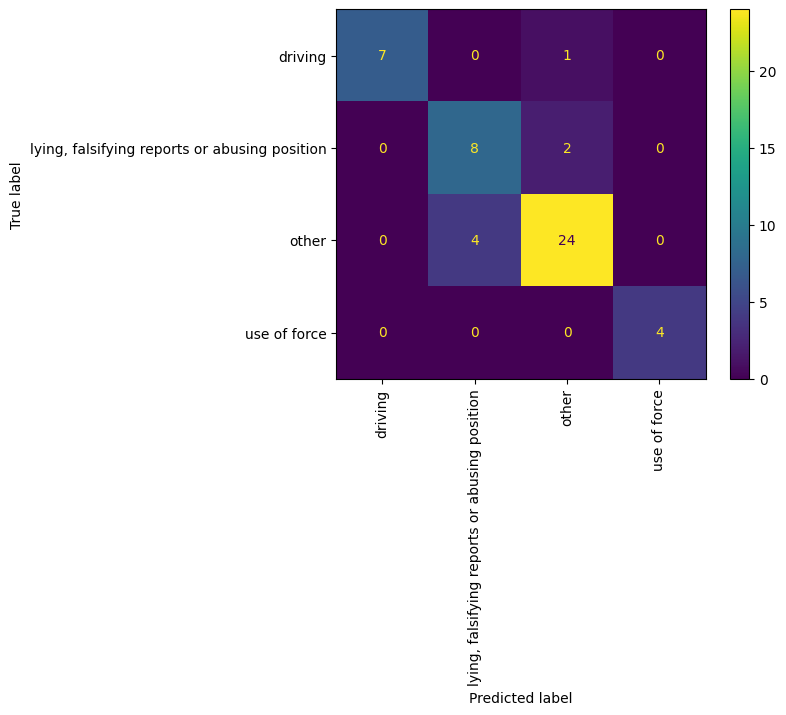

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(handcoded["groundtruth"], handcoded["ai_guess"],  xticks_rotation="vertical");
display(Markdown("""
  This is a confusion matrix, that displays the count of each combo of possible answers and predictions.

  What conclusion do we draw from this?

  What kinds of errors are most common?
  """))

In [ ]:
# calculate baseline
accuracy = accuracy_score(handcoded["groundtruth"], handcoded["ai_guess"])
most_common_answer = handcoded.groupby("groundtruth").count().idxmax().ai_guess
baseline = accuracy_score(handcoded["groundtruth"], [most_common_answer] * len(handcoded["ai_guess"]))


display(Markdown("""is {:.1%} good? Well, let's measure *model skill*. Is the AI _doing anything_?

Let's compare it to the stupidest model possible, that just guesses the most common class ({}) for all outputs. That **baseline** is {:.1%}.

How does {:.1%} compare to {:.1%}?
""".format(
    accuracy,
    most_common_answer,
    baseline,
    accuracy,
    baseline
)))

In [35]:
if accuracy <= baseline:
  new_baseline = accuracy_score(handcoded["groundtruth"], ["NOT INSULTING US PLACE"] * len(handcoded["2-way_category_ai"]))

  display(Markdown("""
    The model is doing worse than (or maybe even with) the baseline.

    But that comparison treats false-positives and false-negatives as equally bad. That might not be right for your problem. For the insults problem,
    all we want to do is shrink the haystack. A baseline that guesses nothing is an insult (as our baseline does) is useless to us. The real
    baseline (reading all of Trump's tweets to find place insults) would be guessing the insult class for everything. That baseline gets {:.1%} --
    way worse than {}. Phew.

    This makes intuitive sense. An AI classification that shrinks the haystack, with a mixture of false-positives and true-positives for us to look at
    is actually really helpful.
  """.format(
      new_baseline,
      accuracy
  )))
else:
  display(Markdown("""
    The model is doing better than baseline.

    But maybe we can do even better. Look at the model's mistakes below, adjust the prompt, and see if the accuracy score (or your chosen metric) goes up.
  """))

with pd.option_context("display.max_colwidth", 500):
  display(
      handcoded[handcoded["ai_guess"] != handcoded["groundtruth"]][["Charge.description", "groundtruth", "ai_guess"]]
  )


    The model is doing better than baseline.

    But maybe we can do even better. Look at the model's mistakes below, adjust the prompt, and see if the accuracy score (or your chosen metric) goes up.
  

,Charge.description,groundtruth,ai_guess
9,FAILED TO SAFEGUARD HIS DEPARTMENT SHIELD AS REQUIRED.,other,"lying, falsifying reports or abusing position"
10,"WHILE ON-DUTY, CONDUCTED A STRIP SEACH OF AN INDIVIDUAL KNOWN TO THE DEPARTMENT WITHOUT SUFFICIENT LEGAL AUTHORITY.","lying, falsifying reports or abusing position",other
20,FAILED TO MAINTAIN ACTIVITY LOG.,"lying, falsifying reports or abusing position",other
22,"SAID POLICE OFFICER, HAVING BEEN DIRECTED BY THE INTERNAL AFFAIRS BUREAU TO REFRAIN FROM ASSOCIATING WITH A PERSON KNOWN TO THE DEPARTMENT DUE TO HIS CRIMINAL HISTORY, DID FAIL AND NEGLECT TO COMPLY WITH SAID ORDER.",other,"lying, falsifying reports or abusing position"
30,Refused to submit to a breathalyzer.,driving,other
33,"WHILE OFF-DUTY, DID WRONGFULLY IMPEDE AN INVESTIGATION CONDUCTED BY CON EDISON.",other,"lying, falsifying reports or abusing position"
42,"WHILE ON-DUTY AND UPON RECEIVING FOUND PROPERTY, DISCARDED THE FOUND PROPERTY IN A GARBAGE CAN.",other,"lying, falsifying reports or abusing position"


#### Suppose we only care about one topic.

Maybe your editor decides that we don't care about politics anymore. Just whether Elon's tweets are about his companies. Now, we just have a true-false classification problem.


  This is a confusion matrix, that displays the count of each combo of possible answers and predictions.

  What conclusion do we draw from this?

  What kinds of errors are most common?
  

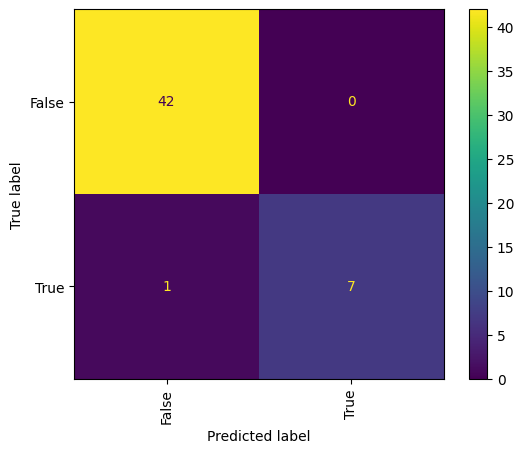

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(handcoded["groundtruth"] == NYPDDecisionOptions.driving, handcoded["ai_guess"] == NYPDDecisionOptions.driving,  xticks_rotation="vertical");
display(Markdown("""
  This is a confusion matrix, that displays the count of each combo of possible answers and predictions.

  What conclusion do we draw from this?

  What kinds of errors are most common?
  """))

The rate of false positives is how many non-company tweets we mistakenly said were about his companies.

The rate of false negatives is how many company tweets we missed.

The inverse of the false positive rate is the true positive rate, or **precision**.

The inverse of the false negative rate is the true negative rate. That's **recall**.


In [155]:

from sklearn.metrics import precision_score, recall_score
display(Markdown("Precision score: {:.1%}. Is that good?".format(
    precision_score(handcoded["groundtruth"] == NYPDDecisionOptions.driving, handcoded["ai_guess"] == NYPDDecisionOptions.driving)
)))


from sklearn.metrics import precision_score, recall_score
display(Markdown("Recall score: {:.1%}. Is that good?".format(
    recall_score(handcoded["groundtruth"] == NYPDDecisionOptions.driving, handcoded["ai_guess"] == NYPDDecisionOptions.driving)
)))


Precision score: 100.0%. Is that good?

Recall score: 88.9%. Is that good?

Which do we care about more? Precision or recall? (You tell me!)

These concepts (accuracy, model skill, precision and recall) might be what you'd put in your methodology to prove that your AI was reliable enough. Can you think of situations where you'd use one or another?

We're going to talk about how to improve our prompts (back in Powerpoint)

## Try a new prompt

And we will see if it does better or worse.

To start out with, try one of these:

- cajoling the model to do a better job

- giving it some examples, based on the errors we saw above

In [49]:
new_prompt_base = """

Please place this description of an administrative charge from the NYPD Trial Decision Library decisions into one of these categories, telling me
only the category name. Choose only from these options: {categories}

Here is the description: {description_text}

Use these definitions: driving refers to any charges involving reckless operation of vehicles, using parking placards improperly, driving while under the influence
of alcohol, or failing to report motor accidents. Force means any charge that involves a physical altercation or the word force, or inappropriate restraint.
integrity means any situation where an officer made misleading statements, interfered with an investigation, used their authority improperly, falsified a report or failed to file one.

Here is an example: Description: FAILED TO COOPERATE WITH A CCRB INVESTIGATION, TO WIT: HE PROVIDED INACCURATE OR MISLEADING STATEMENTS TO CCRB INVESTIGATORS REGARDING A POLICE ENCOUNTER HE HAD WITH A PERSON KNOWN TO THE DEPARTMENT. Classification: integrity

Here is another example: Description: OPERATED A MOTOR VEHICLE IN A RECKLESS MANNER. Classification: driving

"""

data_sample_new_prompt_column = handcoded.apply(lambda row: new_prompt_base.format(
    description_text=row[text_column_name],
    categories=", ".join(['"{}"'.format(opt.value) for opt in NYPDDecisionOptions])
), axis="columns")
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(data_sample_new_prompt_column))
"Sample would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_sample))



'Sample would cost: $0.01'

In [50]:
handcoded["new_ai_guess"] = data_sample_new_prompt_column.progress_apply(classify)

  0%|          | 0/50 [00:00<?, ?it/s]

In [51]:
accuracy = accuracy_score(handcoded["groundtruth"], handcoded["new_ai_guess"])
original_prompt_accuracy = accuracy_score(handcoded["groundtruth"], handcoded["ai_guess"])

In [52]:
display(Markdown("""
  Your new prompt got an accuracy rate of {}. Is that better than {}?

  Should we be using a different metric? (You tell me!)

  Keep trying new stuff until it's good enough (whatever that means!) or you get bored.

  Then you can classify the whole dataset.
""".format(accuracy, original_prompt_accuracy)))


  Your new prompt got an accuracy rate of 0.92. Is that better than 0.86?

  Should we be using a different metric? (You tell me!)

  Keep trying new stuff until it's good enough (whatever that means!) or you get bored.

  Then you can classify the whole dataset.


In [ ]:
## cost estimation for full dataset
token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(full_data_prompt_column))
"Full dataset would cost: ${:.2f}".format(estimate_cost(MODEL_TO_USE, token_count_full))

## Doing the whole thing

Once we're ready, and we think we've accounted for most of the mistakes, we're ready to classify the WHOLE THING.

In [53]:
# since running the AI over the whole dataset might cost a real amount of money
# this is just an extra check to make sure you want to do it.
# just hit enter (or type anything) to continue
# hit stop (to the left of this cell) to stop
okay_to_do_the_whole_thing = input()

In [55]:
## creating response generator -- full dataset

# we're using the most recent "new prompt"

data_full_prompt_column = new_prompt_base + data[text_column_name]

In [56]:
## classifying full prompt

data["ai_guess"] = data_full_prompt_column.progress_apply(classify)

  0%|          | 0/4534 [00:00<?, ?it/s]

TypeError: bad operand type for unary +: 'str'

In [58]:
data.to_csv('nypd_internal_classified.csv')

In [59]:
data.value_counts('ai_guess')

ai_guess
other                                            1771
lying, falsifying reports or abusing position    1610
driving                                           671
use of force                                      482
Name: count, dtype: int64

In [73]:
data['Officer.Name'].nunique()

1654

In [74]:
data['Case'].nunique()

1818

In [75]:
data[data['Disposition']=='Guilty']['ai_guess'].value_counts()

Series([], Name: count, dtype: int64)

In [76]:
driving = data[data['ai_guess'] =='driving']

In [77]:
driving['Case'].nunique()

336

In [67]:
driving.to_csv('driving_ai_guess.csv')